In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
save_dir = '/content/drive/MyDrive/Colab Notebooks/mushroom_saves'
os.makedirs(save_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("/content/mushrooms_small.zip", 'r') as zObject:

    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall(
        path="/content")

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from torchvision import transforms


class MushroomDataset(Dataset):
    """Кастомный датасет для работы с папками классов"""
    def __init__(self, root_dir, transform=None, target_size=None):
        """
        Args:
            root_dir (str): Путь к папке с классами
            transform: Первичная аугментации для изображений
            target_size (tuple): Размер для ресайза изображений
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size

        # Получаем список классов (папок)
        self.ediable_cls = sorted([d for d in os.listdir(root_dir)   if os.path.isdir(os.path.join(root_dir, d))])
        self.ediable2idx = {cls_name: idx for idx, cls_name in enumerate(self.ediable_cls)}

        self.mushroom_cls = [os.listdir(os.path.join(root_dir, dir_name)) for dir_name in self.ediable_cls]
        self.mushroom_cls = [d for mushdir in self.mushroom_cls for d in mushdir]
        self.mushroom2idx = {cls_name: idx for idx, cls_name in enumerate(self.mushroom_cls)}


        # Собираем все пути к изображениям
        self.images = []
        self.labels: list[dict] = []

        for ed_name in self.ediable_cls:
            ediable_dir = os.path.join(root_dir, ed_name)
            ediable_id = self.ediable2idx[ed_name]

            for mush_name in os.listdir(ediable_dir):
                class_dir = os.path.join(ediable_dir, mush_name)
                mush_id = self.mushroom2idx[mush_name]

                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        img_path = os.path.join(class_dir, img_name)
                        self.images.append(img_path)
                        self.labels.append({'ed_id': ediable_id,
                                            'mush_id': mush_id})


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Загружаем изображение
        image = Image.open(img_path).convert('RGB')

        # Ресайзим изображение
        if self.target_size:
            image = image.resize(self.target_size, Image.Resampling.LANCZOS)

        # Применяем аугментации
        if self.transform:
            image = self.transform(image)

        '''СТАВИМ ТОЛЬКО!!! ed_id '''
        return image, label['ed_id']

    def get_mushrooms_name(self):
        """Возвращает список имен видов грибов"""
        return self.mushroom_cls

    def get_ediable_name(self):
        """Возвращает список о съедобности"""
        return self.ediable_cls

In [ ]:
# Загрузка датасета без аугментаций с преобразованием PIL --> torch.tensor()
transform = transforms.ToTensor()

root_train = 'mushroom_dataset'
data = MushroomDataset(root_train, transform=transform, target_size=(224, 224))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class MushroomCNNResNetClassifier(nn.Module):
    def __init__(self, input_channels=3, num_cls=4, drop_coef=0.25):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=input_channels,
                                              out_channels=64,
                                              kernel_size=3,
                                              stride=1,
                                              padding=1),
                                   nn.BatchNorm2d(64))


        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 5, 1, 2),
                                    nn.BatchNorm2d(128))

        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, 5, 1, 2),
                            nn.BatchNorm2d(256))

        self.layer4 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1),
                            nn.BatchNorm2d(256))

        self.layer5 = nn.Sequential(nn.Conv2d(256, 128, 5, 1, 2),
                    nn.BatchNorm2d(128))

        self.layer6 = nn.Sequential(nn.Conv2d(128, 64, 3, 1, 1),
                                    nn.BatchNorm2d(64))

        self.layer7 = nn.Sequential(nn.Conv2d(64, 32, 3, 1, 1),
                            nn.BatchNorm2d(32))


        self.fc1 = nn.Linear(32*28*28, num_cls)

        # Дополнительные функции
        self.pool2x2 = nn.MaxPool2d(2, 2)
        self.avgpool2x2 = nn.AvgPool2d(2,2)
        self.dropout = nn.Dropout(drop_coef)
        self.shortcut1 = self.__shortcut(64, 256)
        self.shortcut2 = self.__shortcut(256, 128)
        self.shortcut3 = self.__shortcut(128, 32)
        # F.relu !!!

    def __shortcut(self, in_channels, out_channels):
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
                             nn.BatchNorm2d(out_channels))

    def forward(self, x):
        x = F.relu(self.layer1(x)) # [3, 224, 224] --> [64, 224, 224]

        residual = x # [64, 224, 224]

        x = self.dropout(F.relu(self.layer2(x))) # [64, 224, 224] --> [128, 224, 224]
        x = self.avgpool2x2(F.relu(self.layer3(x))) # [128, 224, 224] --> [256, 112, 112]


        residual = self.avgpool2x2(self.shortcut1(residual))
        x = x + residual  # [256, 112, 112]

        residual = x  # [256, 112, 112]

        x = self.dropout(F.relu(self.layer4(x))) # [256, 112, 112] --> same
        x = self.pool2x2(F.relu(self.layer5(x))) # [256, 112, 112] --> [128, 56, 56]

        residual = self.pool2x2(self.shortcut2(residual))
        x = x + residual  # [128, 56, 56]
        residual = x   # [128, 56, 56]

        x = self.dropout(F.relu(self.layer6(x)))   # [128, 56, 56] --> [64, 56, 56]
        x = self.avgpool2x2(F.relu(self.layer7(x))) # [64, 56, 56] --> [32, 28, 28]

        residual = self.avgpool2x2(self.shortcut3(residual))
        x = x + residual  #  [32, 28, 28]


        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


def run_epoch(model, data_loader, criterion, optimizer=None, device='cuda:0', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()

    total_loss = 0
    correct = 0
    total = 0

    # Переносим модель на устройство
    model.to(device)

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)

        if not is_test and optimizer is not None:
            optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    return total_loss / len(data_loader), correct / total


def train_model(model:nn.Module, train_loader, test_loader, epochs=10, lr=0.001, device='cuda:0'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    best_acc = 0.0

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        torch.save({
                'epoch': epoch+1,
                'model_params': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_losses': train_losses,
                'train_accs': train_accs,
                'test_losses': test_losses,
                'test_accs': test_accs
            }, f'{save_dir}/resnet_last_checkpoit.pt')


        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch+1,
                'model_params': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': test_loss,
                'accuracy': test_acc
            }, f'{save_dir}/resnet_best_model.pt')


    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }

In [ ]:
# CNNResNet = MushroomCNNResNetClassifier()

from torch.utils.data import random_split

train_size = int(0.8 * len(data))
test_size = len(data) - train_size

# Делим на train, test выборки
train_dataset, test_dataset = random_split(data, [train_size, test_size])

# Создаём DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
metrics = train_model(CNNResNet, train_loader, test_loader, epochs=30, lr=0.001, device='cuda:0')

 63%|██████▎   | 19/30 [2:27:37<1:25:27, 466.18s/it]


KeyboardInterrupt: 

In [ ]:
import torch
import matplotlib.pyplot as plt


def plot_training_history(history):
    """Визуализирует историю обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['test_losses'], label='Test Loss')
    ax1.set_title('Loss')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(history['train_accs'], label='Train Acc')
    ax2.plot(history['test_accs'], label='Test Acc')
    ax2.set_title('Accuracy')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_history(metrics)

## Попробуем pretrained resnet18

In [ ]:
import torchvision
import torch.nn as nn

resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, 4)
resnet18

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from torchsummary import summary
summary(resnet18.to('cuda:0'), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
from torch.utils.data import random_split

train_size = int(0.8 * len(data))
test_size = len(data) - train_size

# Делим на train, test выборки
train_dataset, test_dataset = random_split(data, [train_size, test_size])

# Создаём DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
metrics_resnet = train_model(resnet18, train_loader, test_loader, epochs=30, lr=0.0007, device='cuda:0')

100%|██████████| 30/30 [23:56<00:00, 47.88s/it]


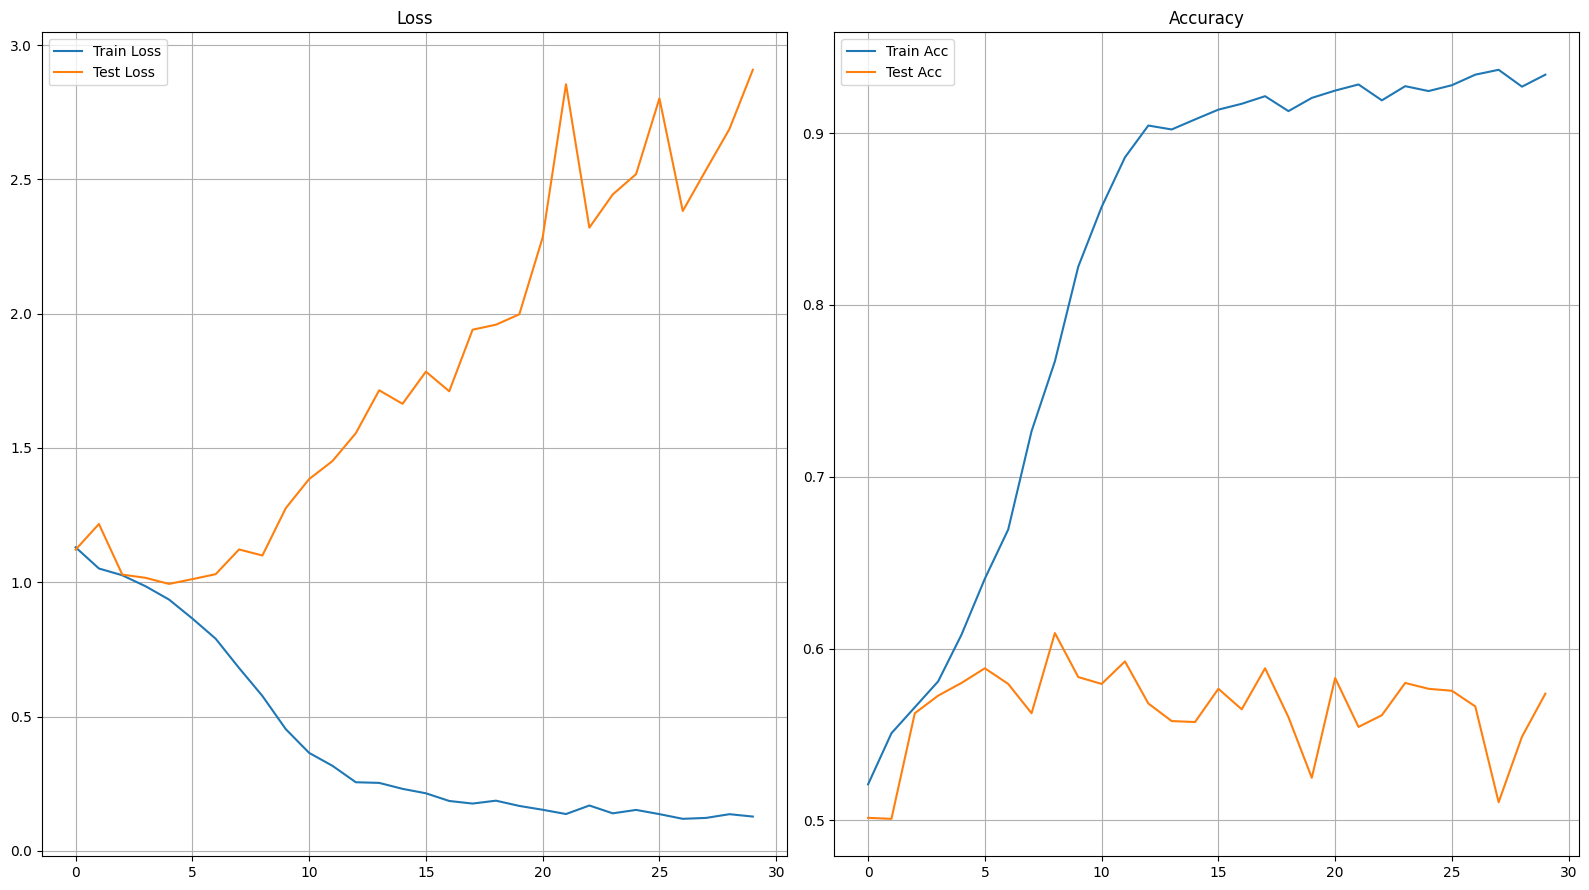

In [ ]:
plot_training_history(metrics_resnet)

Здесь лучашя метрика > 0.6. Попробуем использовать аугментацию, чтобы избежать переобучения

In [ ]:
import copy
import torchvision.transforms as transforms
class AugmentationPipeline:
    # Конфиги
    configs = {
        'light': {
            "RandomHorizontalFlip": transforms.RandomHorizontalFlip(p=0.6),
            "RandomRotation": transforms.RandomRotation(degrees=20)},

        'medium': {
            "RandomHorizontalFlip": transforms.RandomHorizontalFlip(p=0.8),
            "RandomRotation": transforms.RandomRotation(degrees=30),
            "RandomCrop": transforms.RandomCrop(size=(224, 224), padding=20)},

        'heavy': {
            "RandomHorizontalFlip": transforms.RandomHorizontalFlip(p=0.5),
            "RandomRotation": transforms.RandomRotation(degrees=45),
            "RandomGrayscale": transforms.RandomGrayscale(p=1.0),
            "GaussBlur": transforms.GaussianBlur(kernel_size=3)}}

    def __init__(self, config=None):
        self.augmentations = {}
        if config:
            self.augmentations = copy.deepcopy(AugmentationPipeline.configs[config])

    def add_augmentation(self, name, aug):
        """Добавляет аугментацию в пайплайн"""
        self.augmentations[name] = aug

    def remove_augmentation(self, name):
        """Удаляет аугментацию из пайплайна"""
        if name in self.augmentations:
            del self.augmentations[name]

    def apply(self, image):
        """Применяет все аугментации последовательно"""
        for aug_name, aug in self.augmentations.items():
            image = aug(image)
        return image

    def __call__(self, image):
        return self.apply(image)

    def get_augmentations(self):
        """Возвращает словарь всех аугментаций"""
        return self.augmentations.copy()

    # Для использования функций
    def keys(self):
        """Возвращает словарь всех аугментаций"""
        return self.augmentations.copy()


In [ ]:
def run_epoch(model, data_loader, criterion, transform,optimizer=None, device='cuda:0', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()

    total_loss = 0
    correct = 0
    total = 0

    # Переносим модель на устройство
    model.to(device)

    light, medium, heavy = transform
    for batch_idx, (data, target) in enumerate(data_loader):

        if not is_test:
          with torch.no_grad():
              aug1 = torch.stack([light(img) for img in data])
              aug2 = torch.stack([medium(img) for img in data])
              aug3 = torch.stack([heavy(img) for img in data])
              # Объединяем данные
              data = torch.cat([data, aug1, aug2, aug3])
              target = torch.cat([target, target, target, target])


        data, target = data.to(device), target.to(device)


        if not is_test and optimizer is not None:
            optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    return total_loss / len(data_loader), correct / total


def train_model(model:nn.Module, train_loader, test_loader, epochs=10, lr=0.001, device='cuda:0'):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    best_acc = 0.0
    augs = [AugmentationPipeline('light'), AugmentationPipeline('medium'), AugmentationPipeline('heavy')]
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, augs, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, augs, None, device, is_test=True)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        torch.save({
                'epoch': epoch+1,
                'model_params': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_losses': train_losses,
                'train_accs': train_accs,
                'test_losses': test_losses,
                'test_accs': test_accs
            }, f'{save_dir}/resnet_last_checkpoit_aug.pt')


        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch+1,
                'model_params': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': test_loss,
                'accuracy': test_acc
            }, f'{save_dir}/resnet_best_model_aug.pt')


    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }

In [ ]:
# Создаём DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
resnet18_aug_metrics =  train_model(resnet18, train_loader, test_loader, epochs=30, lr=0.0007, device='cuda:0')

  3%|▎         | 1/30 [03:29<1:41:03, 209.08s/it]